<a href="https://colab.research.google.com/github/pippahtlin/Extreme-Precipitation/blob/main/univariate_daily.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from sklearn.preprocessing import MinMaxScaler

In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/pippahtlin/Extreme-Precipitation/main/data/precipitation_soi",index_col = "date")
df.index = pd.to_datetime(df.index)
df

,year,month,day,daily rain,binary rain,soi
date,,,,,,
1899-10-11,1899,10,11,3.048000,0,-1
1899-10-12,1899,10,12,2.032000,0,-1
1899-10-13,1899,10,13,33.020000,1,-1
1899-10-14,1899,10,14,0.508000,0,-1
1899-10-15,1899,10,15,0.000000,0,-1
...,...,...,...,...,...,...
2022-12-27,2022,12,27,0.000000,0,1
2022-12-28,2022,12,28,22.859999,0,1
2022-12-29,2022,12,29,0.000000,0,1


<br>

## 2. Split Data
Training set: 60% | Validation set: 20% | Testing set: 20%

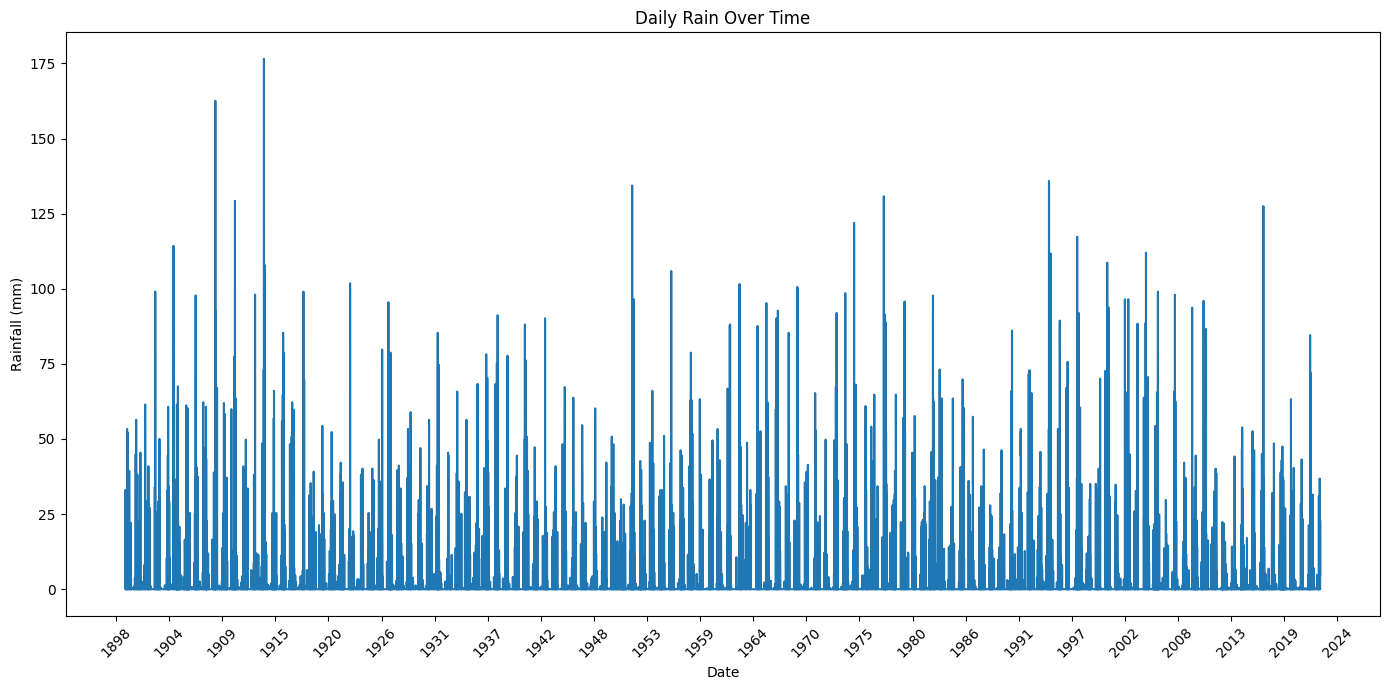

In [3]:
plt.figure(figsize=(14, 7))
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_locator(MaxNLocator(nbins=30))

plt.plot(df.index,df['daily rain'],label = 'Daily Rain')
plt.title('Daily Rain Over Time')
plt.xlabel('Date')
plt.ylabel('Rainfall (mm)')
plt.tight_layout()
plt.show()

In [4]:
# Calculate indices for splitting
total_rows = len(df)
train_end = int(total_rows * 0.6)
validation_end = train_end + int(total_rows * 0.2)

# Using iloc for integer-location based indexing
train = df[["daily rain"]].iloc[:train_end]
validation = df[["daily rain"]].iloc[train_end:validation_end]
test = df[["daily rain"]].iloc[validation_end:]

<br>

## 3. Standardize Data and create series
MinMaxScaler

In [5]:
sc = MinMaxScaler(feature_range=(0,1))
train_scaled = sc.fit_transform(train)
validation_scaled = sc.transform(validation)
test_scaled = sc.transform(test)

print(type(train_scaled))
train_scaled

<class 'numpy.ndarray'>


array([[0.01726619],
       [0.01151079],
       [0.18705036],
       ...,
       [0.        ],
       [0.        ],
       [0.        ]])

In [6]:
T = 90 # Consider seasonality

# Train
X_train = []
y_train = []
for i in range(T,train_scaled.shape[0]):
    X_train.append(train_scaled[i-T:i])
    y_train.append(train_scaled[i])
X_train, y_train = np.array(X_train), np.array(y_train)

# Validation
X_validation = []
y_validation = []

for i in range(T, validation_scaled.shape[0]):
    X_validation.append(validation_scaled[i-T:i])
    y_validation.append(validation_scaled[i])
X_validation, y_validation = np.array(X_validation), np.array(y_validation)

# M, T, N
print(X_train.shape, y_train.shape)
print(X_validation.shape, y_validation.shape)

(26914, 90, 1) (26914, 1)
(8911, 90, 1) (8911, 1)


<br>

## 4. Build LSTM Model

In [7]:
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.layers import Flatten, Dropout
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.regularizers import l2
from time import time

In [8]:
model = Sequential()

# 1st Layer
model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], X_train.shape[2])))
#model.add(Dropout(0.2))

# 2nd Layer
model.add(LSTM(units = 50))
#model.add(Dropout(0.2))

# 3rd Layer
model.add(Dense(units = 1))
model.compile(optimizer = 'adam', loss = 'mean_squared_error')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 90, 50)            10400     
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 30651 (119.73 KB)
Trainable params: 30651 (119.73 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [9]:
model.fit(X_train, y_train, epochs = 50, batch_size = 32)

Epoch 1/50
842/842 [==============================] - 57s 62ms/step - loss: 0.0014
Epoch 2/50
842/842 [==============================] - 54s 64ms/step - loss: 0.0014
Epoch 3/50
842/842 [==============================] - 55s 66ms/step - loss: 0.0013
Epoch 4/50
842/842 [==============================] - 54s 64ms/step - loss: 0.0013
Epoch 5/50
842/842 [==============================] - 54s 64ms/step - loss: 0.0013
Epoch 6/50
842/842 [==============================] - 53s 63ms/step - loss: 0.0013
Epoch 7/50
842/842 [==============================] - 54s 64ms/step - loss: 0.0013
Epoch 8/50
842/842 [==============================] - 54s 64ms/step - loss: 0.0013
Epoch 9/50
842/842 [==============================] - 54s 64ms/step - loss: 0.0013
Epoch 10/50
842/842 [==============================] - 54s 64ms/step - loss: 0.0013
Epoch 11/50
842/842 [==============================] - 54s 64ms/step - loss: 0.0013
Epoch 12/50
842/842 [==============================] - 53s 64ms/step - loss: 0.0013
E

<br>

## 5. Model Evaluation

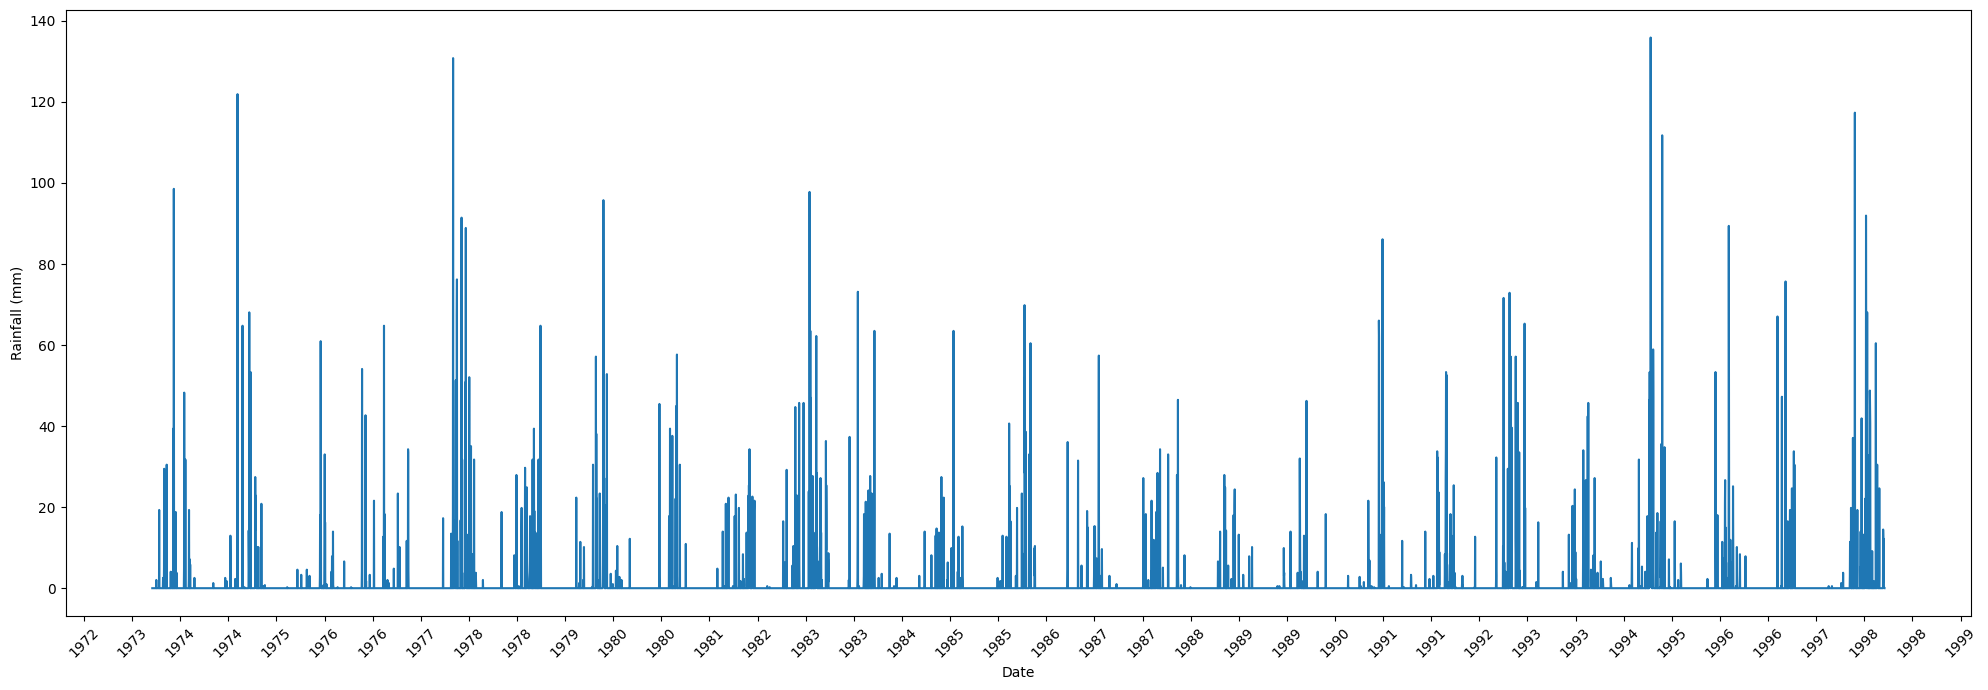

In [15]:
plt.figure(figsize=(20, 7))
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_locator(MaxNLocator(nbins=40))

plt.plot(validation, label = 'Extreme Precipitation')
plt.xlabel('Date')
plt.ylabel('Rainfall (mm)')
plt.tight_layout()
plt.show()

In [16]:
validation_predictions = model.predict(X_validation)
validation_predictions = sc.inverse_transform(validation_predictions)
validation_actual = sc.inverse_transform(y_validation.reshape(-1,1))

279/279 [==============================] - 8s 28ms/step


In [17]:
validation[90:].max()
validation_actual.max()

135.89

In [18]:
validation_compare = pd.DataFrame({'Actual': validation_actual.flatten(), 'Predicted': validation_predictions.flatten()})
validation_compare.head(20)

,Actual,Predicted
0,0.000,0.760360
1,0.000,0.716635
2,0.000,0.676490
3,0.000,0.639458
4,0.000,0.605187
5,0.000,0.573405
6,4.064,0.543891
7,0.000,2.258040
8,0.000,0.886448
9,0.000,0.730426


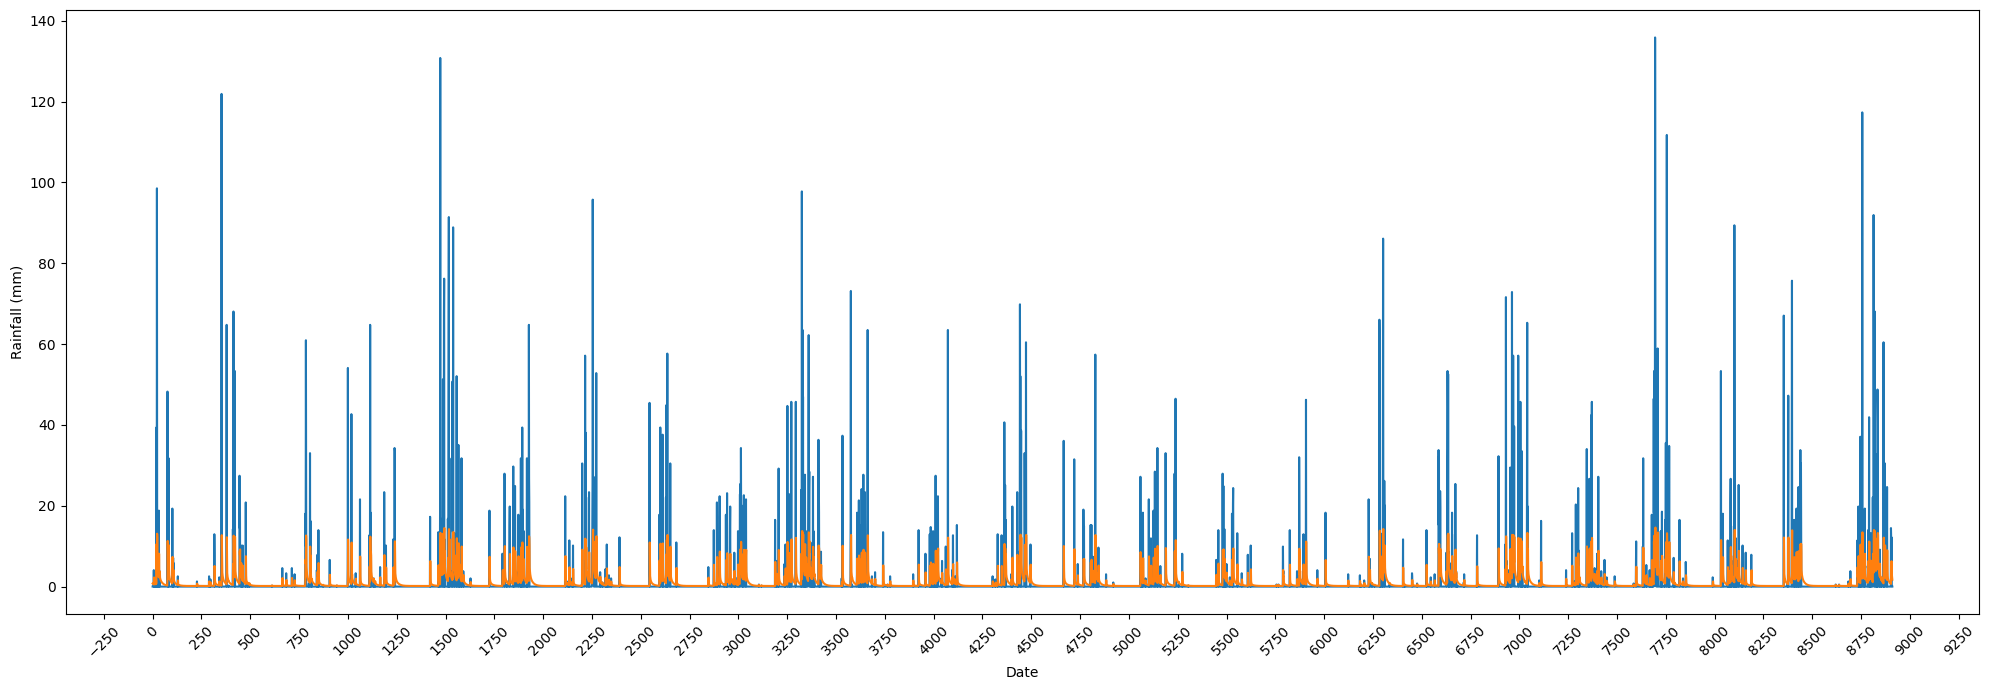

In [19]:
plt.figure(figsize=(20, 7))
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_locator(MaxNLocator(nbins=40))

plt.plot(validation_compare['Actual'])
plt.plot(validation_compare['Predicted'])
plt.xlabel('Date')
plt.ylabel('Rainfall (mm)')
plt.tight_layout()

plt.show()